In [0]:
!pip install arviz

In [8]:
import pystan
import arviz as az
import numpy as np
import scipy.stats as stats
import os
from google.colab import drive
drive.mount('/content/gdrive')
working_directory = 'My Drive/DataAnalytics/'
wd="/content/gdrive/" + working_directory
os.chdir(wd)
import stan_utility

dirpath = os.getcwd()
print("current directory is : " + dirpath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
current directory is : /content/gdrive/My Drive/DataAnalytics


In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [17]:
with open('gamma0.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real gamma = gamma_rng(alpha, beta);
    real invgamma = inv_gamma_rng(alpha, beta);
}


In [18]:
model = stan_utility.compile_model('gamma0.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a9db43afeb8054648fdd21cade5d7b47 NOW.


In [0]:
model2 = model.sampling(data={'alpha': 2, 'beta': 4},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [39]:
gamma = np.round(model2.extract()['gamma'][0])
invgamma = np.round(model2.extract()['invgamma'][0])
print(gamma)
print(invgamma)

1.0
5.0


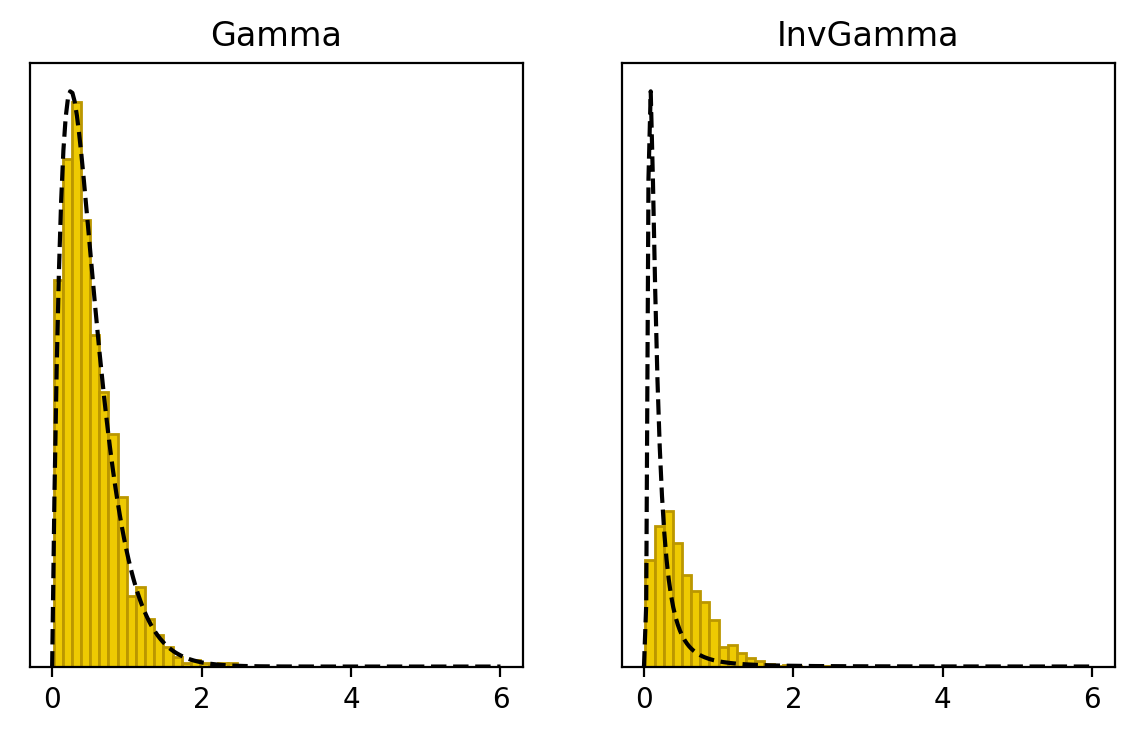

In [55]:
params=model2.extract()
gamma=params['gamma']
invgamma=params['invgamma']

fig, axes = plt.subplots(1, 2,figsize=(7, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,6,200)
alpha = 2
beta = 4
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_yticks([])
ax1.set_title('Gamma')

ax2=axes[1]
ax2.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,6,200)
alpha = 2
beta = 4
ax2.plot(x,stats.invgamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax2.set_yticks([])
ax2.set_title('InvGamma')

plt.show()

In [130]:
with open('gamma_stan.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.98;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {
  vector[1] y;
  real x_r[0];
  int x_i[0];
  
  // Find Gaussian standard deviation that ensures 98% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  
  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
    real sigma = exp(y[1]);
    real beta = (1 / theta[1]);
    real alpha = (sigma * beta) ^ 2;
    
    real gamma = gamma_rng(alpha, beta);
    print("Beta = ", beta);
    print("Alpha = ", alpha);
    print("Gamma = ", gamma);
}


In [131]:
model_prior=stan_utility.compile_model('gamma_stan.stan')

Using cached StanModel


In [132]:
theta=np.array([np.random.randint(low=1, high=10)])
y_guess=np.array([np.random.randint(low=1, high=10)])
data=dict(y_guess=y_guess,theta=theta)
model_prior2 = model_prior.sampling(data=data, algorithm="Fixed_param", iter=1, warmup=0, chains=1, seed=1052020)
sigma = np.round(model_prior2.extract()['sigma'][0])
gamma = np.round(model_prior2.extract()['gamma'][0])
beta = np.round(model_prior2.extract()['beta'][0])
alpha = np.round(model_prior2.extract()['alpha'][0])
print(sigma)
print(alpha)
print(beta)
print(gamma)

3.0
0.0
0.0
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


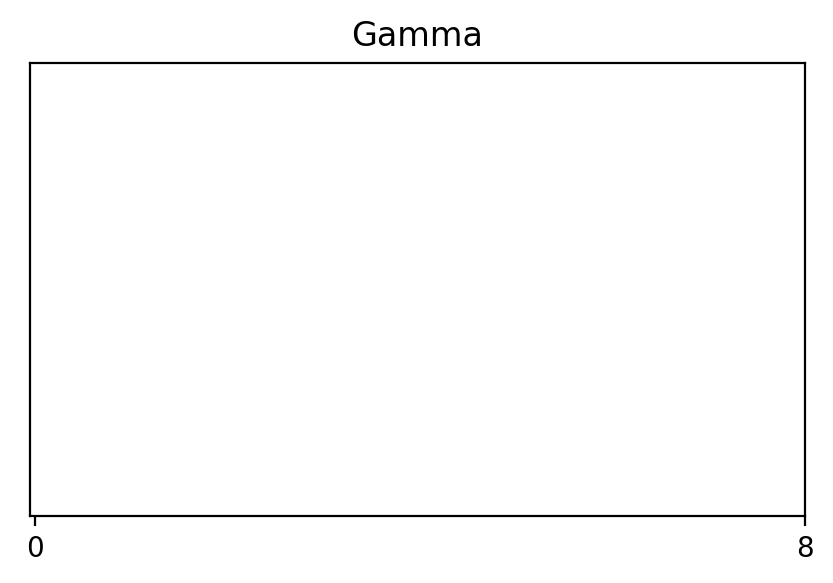

In [134]:
fig, ax2 = plt.subplots(1, 1,figsize=(5, 3))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta[0],1000)
ax2.plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=dark,linewidth=2)
ax2.fill_between(x4,stats.gamma.pdf(x4,a=alpha,scale=1/beta),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta[0]])
ax2.set_title('Gamma')
plt.show()

InvGamma

Negative binomial distribution

In [92]:
with open('negbinomial.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real mean_;
    real phi;
}

generated quantities {
    real negcon = neg_binomial_rng(alpha, alpha/mean_);
    real negdisc = neg_binomial_2_rng(mean_, phi);

    real poissoncon = poisson_rng(negcon);
    real poissondisc = poisson_rng(negdisc);
}


In [93]:
model_negbinomial = stan_utility.compile_model('negbinomial.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d47d999421d693a49472acc4beb25454 NOW.


In [0]:
data = dict(mean_=10, alpha=2, phi=2, M=1000)
model_negbinomial2 = model_negbinomial.sampling(data=data,
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [0]:
params=model_negbinomial2.extract()
negbincon=params['negcon']
poissoncon=params['poissoncon']
negbindisc=params['negdisc']
poissondics=params['poissondisc']

In [0]:
beta = data['alpha']/data['mean_']
x_con=np.linspace(0, 80, 81)
x_dis=np.linspace(0, 45, 46)
nbinom_fun_con = stats.nbinom(data['alpha'], beta/(beta+1))
nbinom_fun_dis = stats.nbinom(data['phi'], data['phi']/(data['mean_']+data['phi']))

nbinom_pmf_con = []
nbinom_pmf_dis = []

for i in range(0, len(x_con)):
    nbinom_pmf_con.append( nbinom_fun_con.pmf( x_con[i] ))
for i in range(0, len(x_dis)):
    nbinom_pmf_dis.append( nbinom_fun_dis.pmf( x_dis[i] ))

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


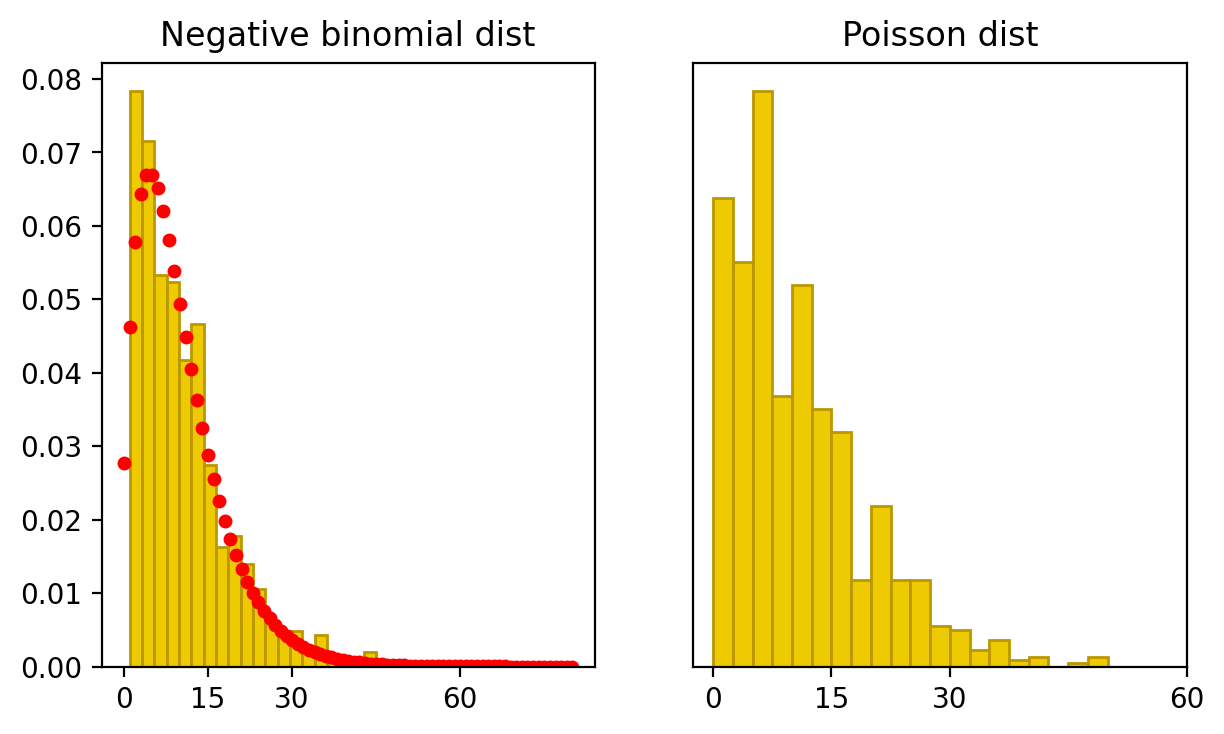

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(negbincon,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.plot(x_con, nbinom_pmf_con,'ro', markersize=4)
ax1.set_xticks([0,15,30,60])
ax1.set_title(r'Negative binomial dist')

ax2=axes[1]
ax2.hist(poissoncon,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,15,30,60])
ax2.set_title('Poisson dist')

plt.show()

Student-t family distributions

In [105]:
with open('student_t.stan', 'r') as file:
    print(file.read())

data {
    real nu;    
    real mu;    
    real sigma; 
}

generated quantities {
    real y_sim = student_t_rng(nu, mu, sigma);
}


In [106]:
model_student_t = stan_utility.compile_model('student_t.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b55136f398b6ae381aa9d552d38eed5 NOW.


In [0]:
R1=10
model_student_t1 = model_student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
R2=100
model_student_t2 = model_student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R2, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [0]:
params1=model_student_t1.extract()
student1=params1['y_sim']

params2=model_student_t2.extract()
student2=params2['y_sim']

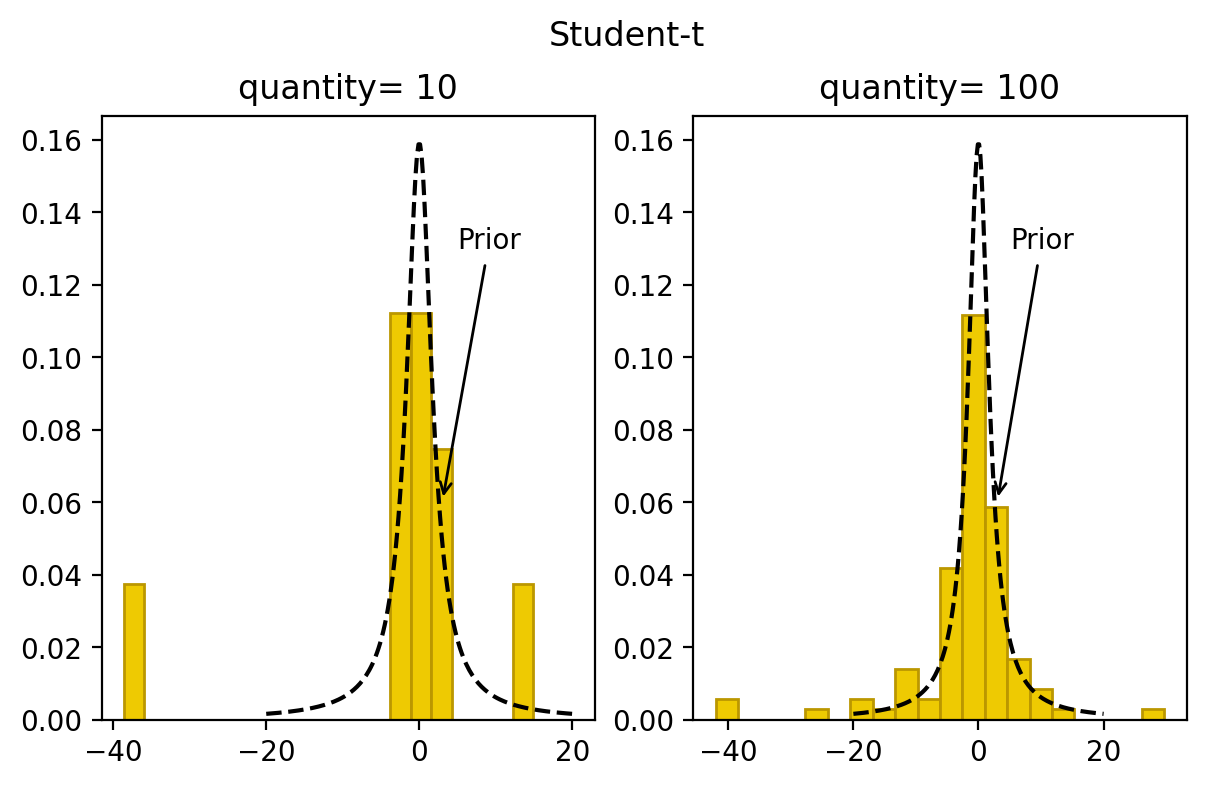

In [111]:
x=np.linspace(-20,20,200)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
fig.suptitle('Student-t',x= 0.5,y=1, fontsize=12)

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
ax1.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'quantity= 10')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
ax2.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax2.set_title(r'quantity= 100')

plt.show()

Multivariate normal distributions

In [112]:
with open('multivariatenormal.stan') as file:
    print(file.read())

data {
    vector[2] mu;       
    matrix[2,2] sigma;  
}


generated quantities {
    vector[2] result = multi_normal_rng(mu,sigma);
}


In [113]:
modelmultivariate = stan_utility.compile_model('multivariatenormal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6a7fdf55f2db70a63db7077b10c6159f NOW.


In [0]:
data = dict(mu=[2.0, 8], sigma=[[1, .3],[.3, 2]])
modelmultivariate2 = modelmultivariate.sampling(data=data,
                                            seed=1052020,
                                            algorithm="Fixed_param",
                                            iter=1000, 
                                            warmup=0,
                                            chains=1)
params_result = modelmultivariate2.extract()
y_sim = params_result['result'].T

In [0]:
y_sim0 = y_sim[0].flatten()
y_sim1 = y_sim[1].flatten()

(array([  1.,   2.,   4.,   9.,  17.,  30.,  43.,  67.,  98., 113., 103.,
        134.,  98.,  98.,  68.,  49.,  34.,  21.,   8.,   3.]),
 array([-1.58487609e+00, -1.26717707e+00, -9.49478039e-01, -6.31779012e-01,
        -3.14079985e-01,  3.61904129e-03,  3.21318068e-01,  6.39017095e-01,
         9.56716121e-01,  1.27441515e+00,  1.59211417e+00,  1.90981320e+00,
         2.22751223e+00,  2.54521125e+00,  2.86291028e+00,  3.18060931e+00,
         3.49830833e+00,  3.81600736e+00,  4.13370639e+00,  4.45140541e+00,
         4.76910444e+00]),
 <a list of 20 Patch objects>)

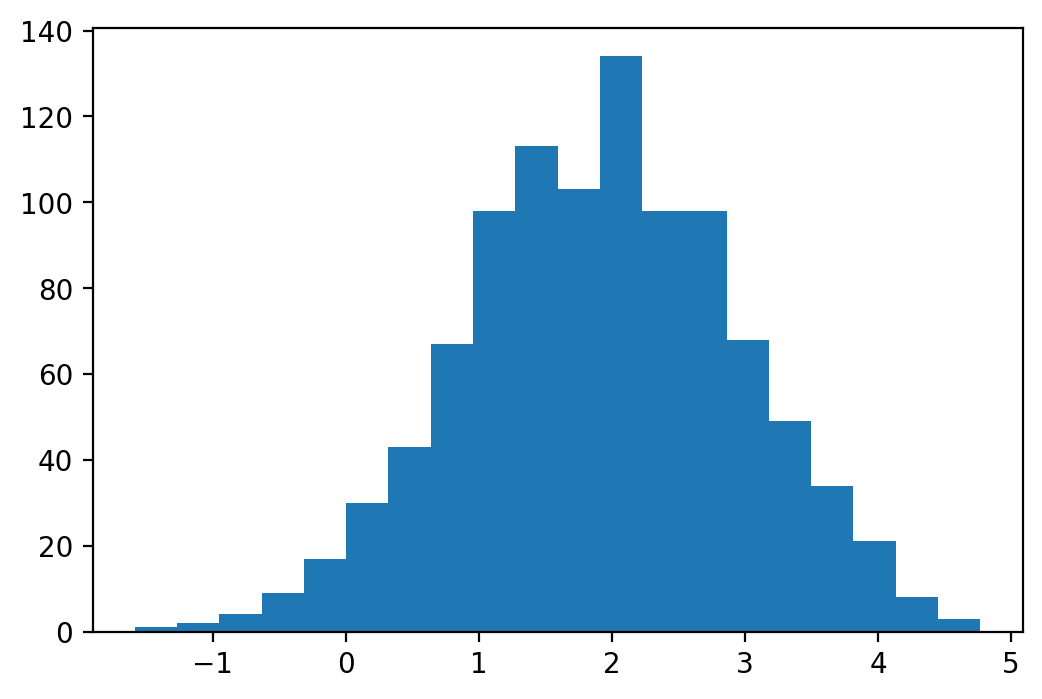

In [127]:
plt.hist(y_sim[0].flatten(), bins=20)